<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2020ccap/2020_0323tlpa_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 転移学習のデモ


In [0]:
# パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import scipy
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [0]:
# 乱数のシードを設定
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

# DataSetを作成

In [0]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)


In [4]:
# データの読み込み
!wget https://github.com/ShinAsakawa/ShinAsakawa.github.io/blob/master/2020ccap/19960222_006.jpg?raw=true
!mv 19960222_006.jpg?raw=true 19960222_006.jpg


--2020-03-23 12:04:32--  https://github.com/ShinAsakawa/ShinAsakawa.github.io/blob/master/2020ccap/19960222_006.jpg?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ShinAsakawa/ShinAsakawa.github.io/raw/master/2020ccap/19960222_006.jpg [following]
--2020-03-23 12:04:32--  https://github.com/ShinAsakawa/ShinAsakawa.github.io/raw/master/2020ccap/19960222_006.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/2020ccap/19960222_006.jpg [following]
--2020-03-23 12:04:32--  https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/2020ccap/19960222_006.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connectin

In [5]:
!wget https://www.cis.twcu.ac.jp/~asakawa/2020ccap/tlpa.pkl
#!wget https://www.cis.twcu.ac.jp/~asakawa/2020ccap/snodgrass.pkl

--2020-03-23 12:04:38--  https://www.cis.twcu.ac.jp/~asakawa/2020ccap/tlpa.pkl
Resolving www.cis.twcu.ac.jp (www.cis.twcu.ac.jp)... 160.13.90.21
Connecting to www.cis.twcu.ac.jp (www.cis.twcu.ac.jp)|160.13.90.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22867719 (22M)
Saving to: ‘tlpa.pkl’

tlpa.pkl            100%[===================>]  21.81M  14.5MB/s    in 1.5s    

2020-03-23 12:04:40 (14.5 MB/s) - ‘tlpa.pkl’ saved [22867719/22867719]



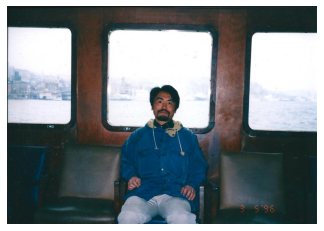

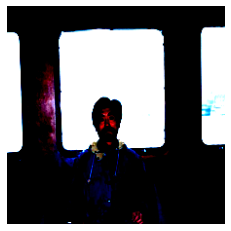

In [6]:
# 訓練時の画像前処理の動作を確認

# 1. 画像読み込み
image_file_path = '19960222_006.jpg'
img = Image.open(image_file_path)

# 2. 元の画像の表示
plt.imshow(img)
plt.axis(False)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.axis(False)
plt.show()


In [0]:
import pickle
#with open(Snodgrass_data_file,'rb') as f:
#    tmp_data = pickle.load(f)

# TLPA データの読み込み
with open('tlpa.pkl', 'rb') as f:
    tmp_data = pickle.load(f)

In [8]:

labels = [tmp_data[it]['label'] for it in tmp_data]
print(labels)


['バス', '緑', '桜', 'のり巻き', '五重塔', 'コップ', 'ごぼう', '土踏まず', '風呂', 'ヒトデ', 'ハム', '兎', 'ロープウエイ', '学校', 'ちりとり', '縁側', '歯', 'ネギ', 'あじさい', '灰色', '天井', '鍵', '肌色', 'ワニ', '電車', '顔', '松', 'ガードレール', '柿', 'ちまき', '信号', 'すすき', 'じょうろ', 'コンセント', '天ぷら', '中指', 'ヨット', 'ピンク', 'ふくろう', 'みかん', '柱', '角砂糖', '犬', 'かご', 'バラ', '鍋', 'まぶた', 'くるみ', '黒', 'デパート', 'カーネーション', '城', '蟻', '豆腐', 'ドライバー', '紺', '階段', '戦車', '人参', '背中', '鏡餅', 'スプーン', '朝顔', '金', '足', 'ふすま', '蛇', 'レモン', '公園', '乳母車', '床', '藤', 'ピンセット', 'トラック', '苺', '黄土色', '銭湯', 'ナマズ', 'そば', 'お腹', 'オレンジ', 'バター', '工場', '鳩', '電卓', '喉仏', 'チューリップ', '白菜', 'トラクター', '廊下', 'パトカー', '押入れ', '鉛筆', '目尻', '芋', '吊り橋', '赤', 'かき氷', '豹', 'サボテン', 'ピラミッド', 'サイ', '目', 'ひまわり', 'はたき', '刺身', '玄関', 'トマト', '黄緑', '三輪車', '鶏', 'つむじ', 'アスパラガス', 'ドア', '銀色', 'すりこ木', 'ウイスキー', '梅', 'タクシー', '動物園', '床の間', '焦げ茶', 'ぶどう', '飴', '毛虫', 'アイロン', '寺', 'そり', 'ひょうたん', '首', '消しゴム', '頬', 'いちょう', '駅', 'ギョウザ', '牛', 'びわ', '飛行機', '畳', '白', '竹', 'ペリカン', '紫', '手すり', '口', '大根', '風車', '鋏', '潜水艦', 'ステーキ', 'マッチ', '二階', '落花生', '御

In [9]:
class tlpaDataset(data.Dataset):
    """
    TLPA 図版 Dataset クラス。PyTorch の Dataset クラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, pkl_list, transform=None, phase='train'):
        with open(pkl_list, 'rb') as f:
            self.data = pickle.load(f)
        self.labels = [self.data[it]['label'] for it in self.data]        
        #self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.labels)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img = Image.fromarray(self.data[index+1]['data'].astype(np.uint8)) # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        #label = self.data[index+1]['id']
        label = index
        
        return img_transformed, label


# 実行
train_dataset = tlpaDataset(
    pkl_list='tlpa.pkl', transform=ImageTransform(size, mean, std), phase='train')

val_dataset = tlpaDataset(
    pkl_list='tlpa.pkl', transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


# DataLoaderを作成

In [10]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)


torch.Size([64, 3, 224, 224])
tensor([124, 121,  27, 169,  67,  46, 139,  38,  88,   1,  16,  37, 197, 129,
        146,  10,  58, 156, 140, 174,   5, 134,  93, 119, 178,   2, 157, 152,
         24, 184, 177, 120, 153, 185,  33, 191,  48, 104,  53,  75, 145,  49,
         95, 117,  14, 144,  26, 195, 100, 131, 138, 123, 165,  60,  52, 199,
        113, 189, 180, 192, 179,  89,  56,  55])


# ネットワークモデルの作成

In [23]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.resnet50(pretrained=use_pretrained)

# 最後の出力層の出力ユニットを変更
net.fc = nn.Linear(in_features=2048, out_features=200)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')


ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [24]:
#!pip install torchsummary
#import torchsummary
#torchsummary.summary(net,input_size=(3,224,224), device='cuda')
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 損失関数の定義

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定

In [26]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["fc.weight", "fc.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)


fc.weight
fc.bias
-----------
[Parameter containing:
tensor([[ 0.0065,  0.0054, -0.0015,  ..., -0.0094, -0.0062, -0.0119],
        [-0.0149,  0.0194,  0.0029,  ..., -0.0135,  0.0135, -0.0174],
        [ 0.0126,  0.0149,  0.0025,  ...,  0.0112, -0.0189,  0.0180],
        ...,
        [ 0.0068,  0.0188,  0.0118,  ..., -0.0098, -0.0045, -0.0107],
        [-0.0105, -0.0191,  0.0173,  ..., -0.0042,  0.0031, -0.0030],
        [ 0.0171, -0.0162,  0.0068,  ..., -0.0075, -0.0099,  0.0060]],
       requires_grad=True), Parameter containing:
tensor([-1.9639e-04,  1.0855e-02,  8.7489e-03,  9.5426e-03,  9.2633e-03,
        -1.9114e-03, -1.7418e-03, -1.6893e-02, -1.6392e-02,  2.2631e-06,
        -1.4779e-02,  1.3415e-02, -1.3905e-03,  5.2852e-03,  5.7086e-03,
        -3.6924e-03,  1.0049e-02,  1.7046e-02,  1.1050e-02,  4.7079e-03,
        -6.1514e-03, -3.4763e-03,  1.0075e-02, -1.5350e-03, -1.6752e-03,
         5.9184e-04, -8.3205e-03, -1.4946e-02,  1.5514e-02,  1.9205e-02,
        -1.8348e-03,  1.6

In [0]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)


# 学習・検証を実施

In [0]:
# モデルを学習させる関数を作成

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


In [0]:
# 学習・検証を実行する
num_epochs=10
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/10
-------------



100%|██████████| 4/4 [00:30<00:00,  7.64s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.3320 Acc: 0.0100
Epoch 2/10
-------------



100%|██████████| 4/4 [00:37<00:00,  9.31s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.3752 Acc: 0.0000
